## Introduction
**Chapter 9. 기계 독해(Machine Reading Comprehension) Task** 강의의 **한국어 기계 독해 실습 (2) 기계 독해 모델 학습 및 평가** 강의입니다.

이번 실습에서는 이전 실습 강의에서 진행했던 한국어 기계 독해 모델을 학습하기 위한 한국어 기계 독해 데이터셋(KorQuAD) 수집 및 전처리 과정에 이어서, Huggingface의 Multilingual T5 모델을 기반으로하는 한국어 기계 독해 모델을 직접 학습하고 평가해봅니다.

In [1]:
!pip install datasets==1.4.1
!pip install transformers==4.4.1
!pip install sentencepiece==0.1.95
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 4.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.9 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. 데이터셋 수집

Chapter 9 강의의 실습에서 사용할 데이터셋은 한국어 기계 독해 데이터셋 (KorQuAD)으로,

그 중 KorQuAD 1.0은 한국어 기계 독해 작업(Machine Reading Comprehension)을 위해 만든 데이터셋입니다.

데이터셋 내 모든 질문에 대한 답변은 해당 Wikipedia article 문단의 일부 하위 영역으로 구축되었으며,

Stanford Question Answering Dataset(SQuAD) v1.0과 동일한 방식으로 구성되었습니다.

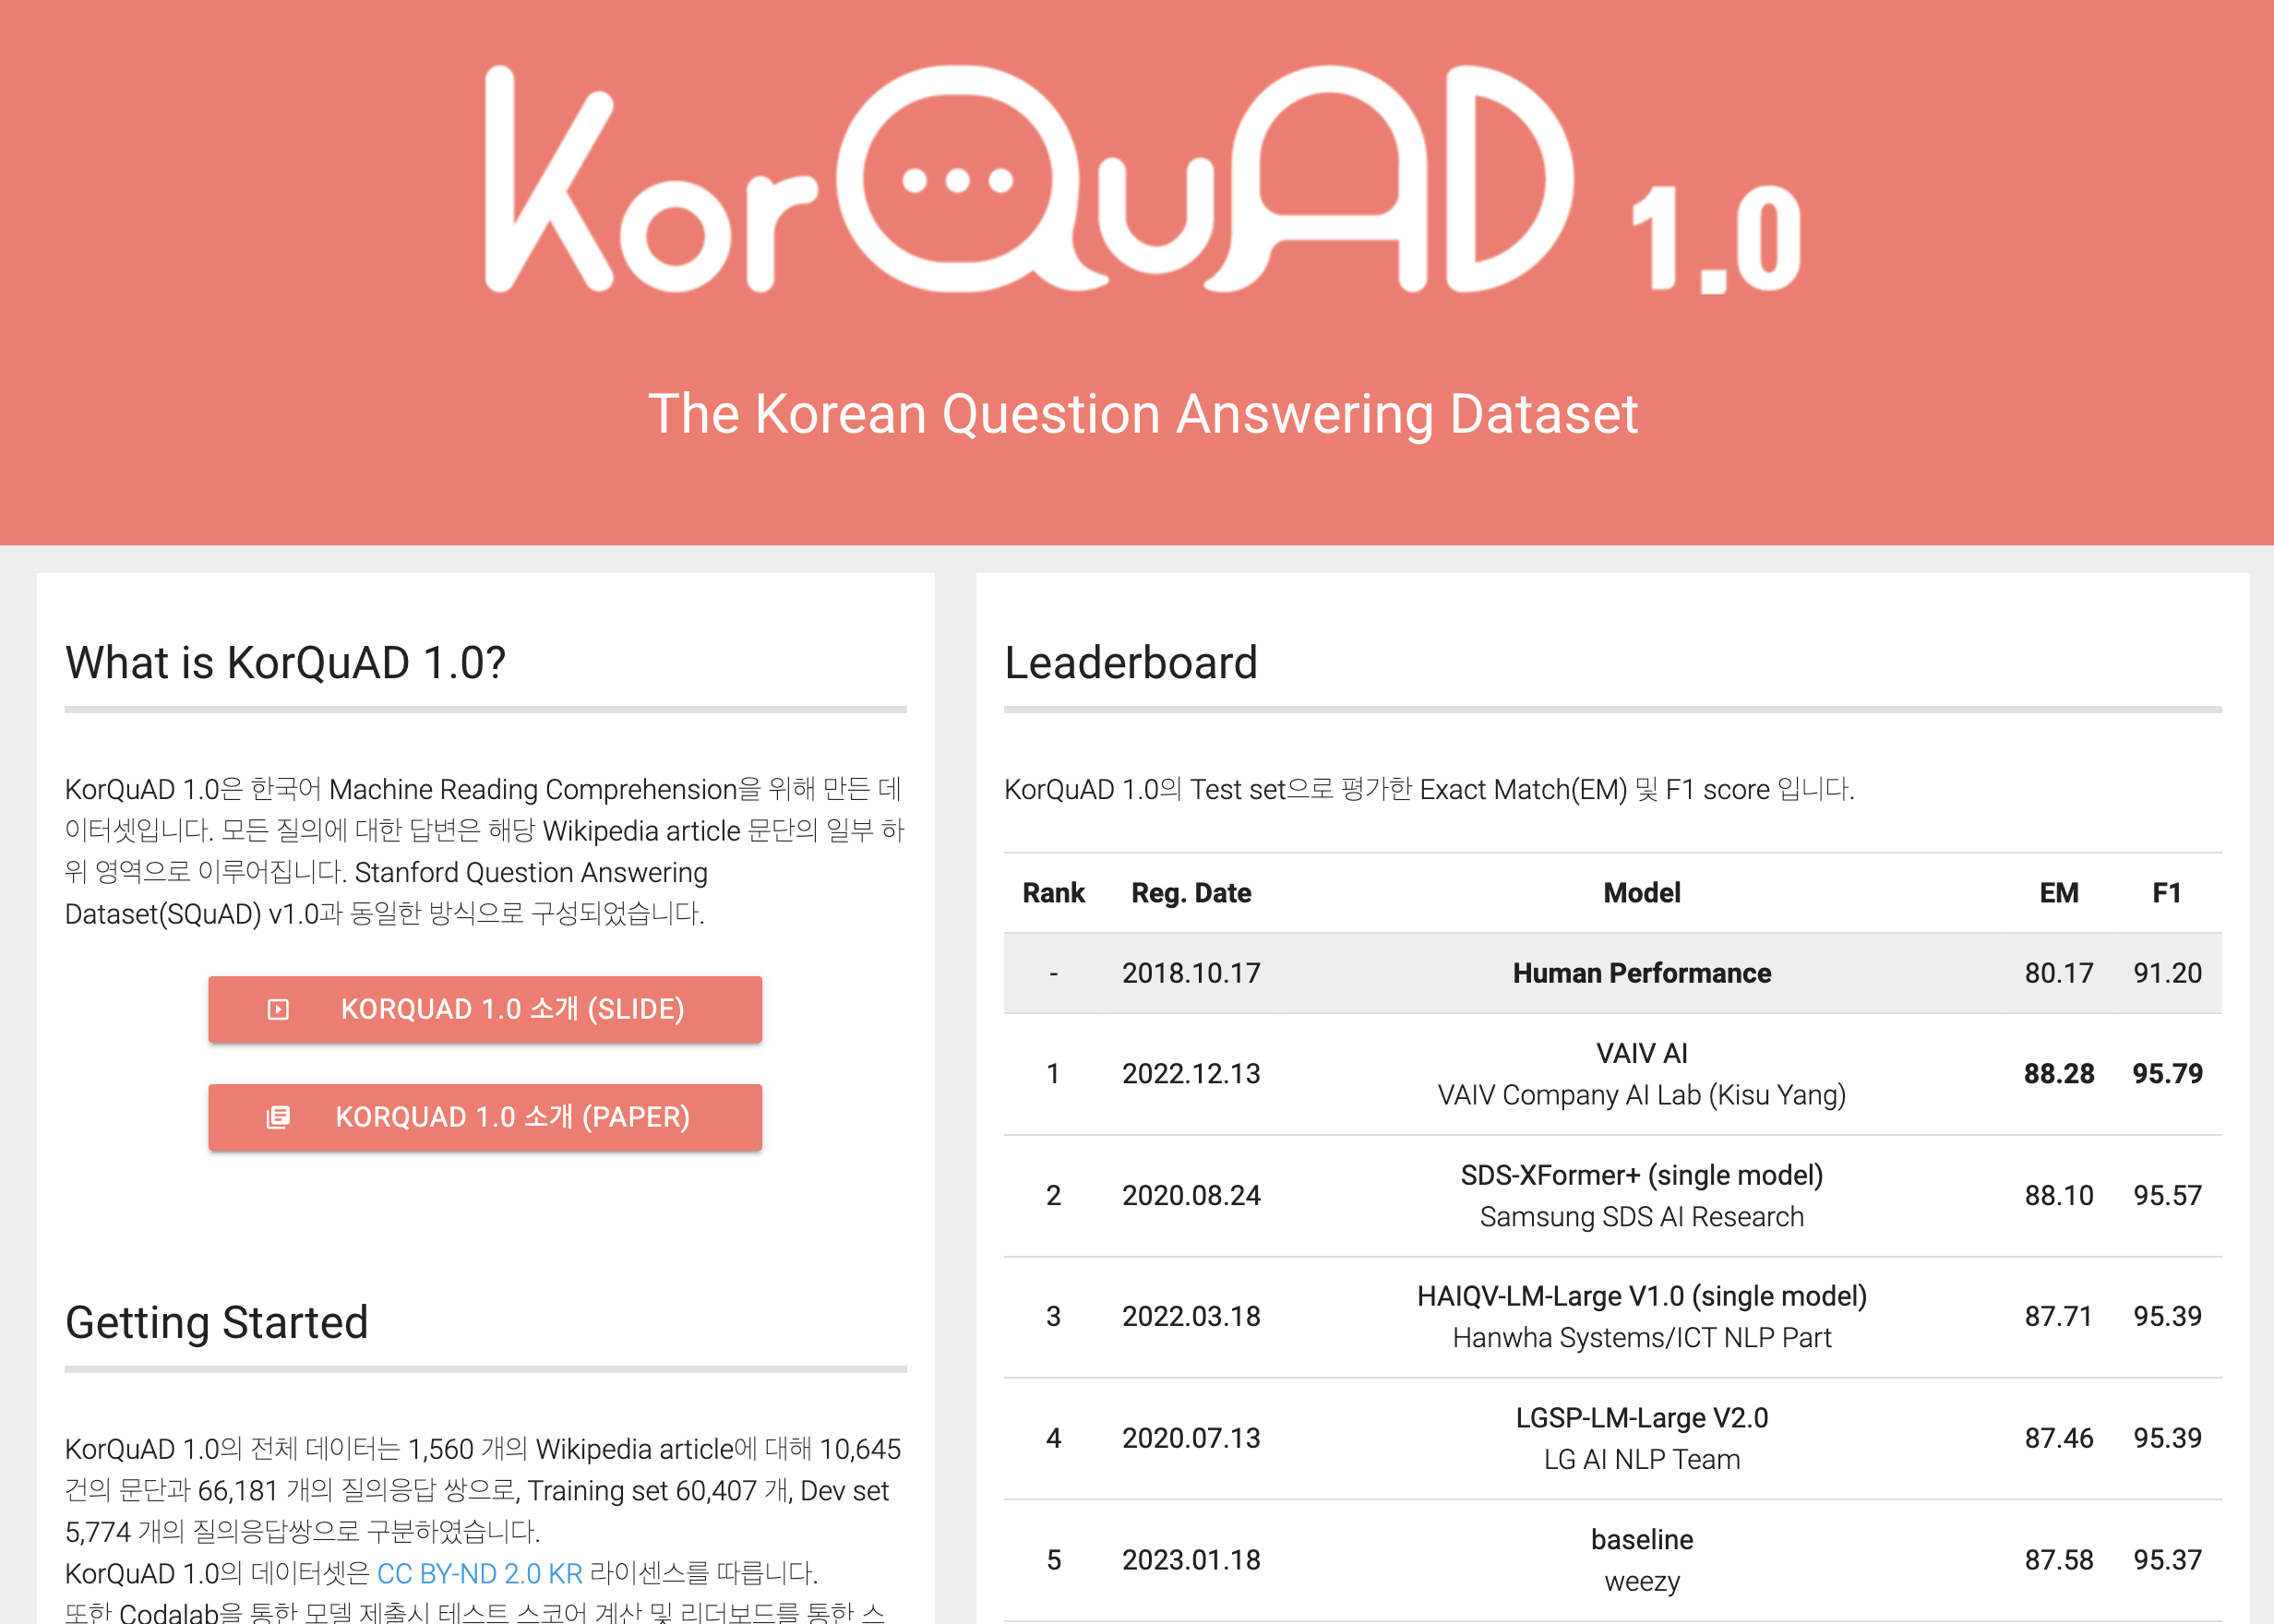

### 1.1. 데이터셋 특징

KorQuAD 1.0의 전체 데이터는 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍에서 수집되었으며,

학습 데이터셋은 60,407 개, Dev set 5,774 개의 질의응답쌍으로 분리됩니다.

KorQuAD 데이터셋은 원본 링크에서 직접 다운로드 받을 수 있으나,

오늘 실습에서는 Huggingface의 dataset hub를 이용하여 데이터셋을 로드합니다.

*   KorQuAD 원본 링크 : https://korquad.github.io/KorQuad%201.0/
*   Huggingface datasets : https://huggingface.co/datasets/squad_kor_v1

In [3]:
from datasets import load_dataset

In [5]:
datasets = load_dataset("squad_kor_v1")

## 2. 사전학습 모델 및 토크나이저 로드

오늘 실습에서는 Huggingface hub에 등록되어있는, google의 Multilingual T5(mT5) 모델을 사용합니다.

Multilingual T5(mT5)는 2021년도에 [mT5: A Massively Multilingual Pre-trained Text-to-Text Transformer](https://aclanthology.org/2021.naacl-main.41/) 논문에서 제안된 다국어 언어 모델입니다.

mT5 모델은 대규모 다국어 병렬 코퍼스로 사전학습된 Transformer 모델로, T5 모델과 유사한 학습 방법을 따라 훈련됩니다.

Multilingual T5의 코드는 [여기](https://github.com/google-research/multilingual-t5)에서 확인할 수 있으며, [논문](https://aclanthology.org/2021.naacl-main.41/)의 실험을 재현하는데 사용할 수 있습니다.

Huggingface hub에 등록된 Multilingual T5(mT5) 모델: https://huggingface.co/google/mt5-small

In [6]:
from transformers import AutoConfig, AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [7]:
model_name = "google/mt5-small"

In [8]:
config = AutoConfig.from_pretrained(
  model_name,
  cache_dir="./cache",
)

In [9]:
config

MT5Config {
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.4.1",
  "use_cache": true,
  "vocab_size": 250112
}

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  cache_dir="./cache",
  use_fast=True,
)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
model = AutoModelForSeq2SeqLM.from_pretrained(
  model_name,
  cache_dir="./cache",
  config=config,
)

In [13]:
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedGeluDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (w

## 3. 데이터셋 전처리

모델 학습 시 입력으로 넣기 위해 데이터셋을 전처리하는 함수를 작성합니다.

이 때, 문맥(context)과 질문(question)을 concat하여 source로 정의하고, 답변(answer)을 target으로 정의합니다.

In [14]:
max_source_length = 1024
max_target_length = 128

In [15]:
def preprocessing(dataset):
    inputs = [f'question: {question}  context: {context} </s>' for question, context in zip(dataset['question'], dataset['context'])]
    targets = [f'{answer["text"][0]} </s>' for answer in dataset['answers']]
    
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=False, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, padding=False, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    model_inputs["sample_id"] = []
    
    for i in range(len(model_inputs["labels"])):
        model_inputs["sample_id"].append(dataset["id"][i])
    
    return model_inputs

In [16]:
column_names = datasets['train'].column_names

In [17]:
column_names

['answers', 'context', 'id', 'question', 'title']

In [18]:
datasets["train"][0]

{'answers': {'answer_start': [54], 'text': ['교향곡']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-0',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'title': '파우스트_서곡'}

데이터 정제에 필요한 파라미터를 정의합니다.

In [19]:
preprocessing_num_workers=12

효율적인 실습을 위하여, 학습 데이터셋과 평가 데이터셋을 각각 1000개, 100개로 정의합니다.

In [20]:
num_train_dataset = 1000
num_valid_dataset = 100

In [ ]:
train_dataset = datasets["train"]
train_dataset = train_dataset.select(range(num_train_dataset))
train_dataset = train_dataset.map(
    preprocessing,
    batched=True,
    num_proc=preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=False,
)

In [ ]:
valid_dataset = datasets["validation"]
valid_dataset = valid_dataset.select(range(num_valid_dataset))
valid_dataset = valid_dataset.map(
    preprocessing,
    batched=True,
    num_proc=preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=False,
)

## 4. 모델 학습

이전 실습에서처럼 transformer의 Trainer Class를 사용하여 모델 학습을 모듈화하여 실행합니다.

In [23]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

In [24]:
pad_token_id = tokenizer.pad_token_id
pad_token_id

0

In [25]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=pad_token_id,
    pad_to_multiple_of=None,
)

모델의 평가 메트릭과 평가 함수를 정의합니다.

KorQuAD 1.0의 데이터셋을 Huggingface hub를 통해 불러오면, 다음과 같이 해당 데이터셋의 메트릭을 사용할 수 있음

KorQuAD 1.0의 벤치마크 메트릭은 Exact Match(EM)과 F1 score입니다.

In [26]:
from datasets import load_metric

In [27]:
metric = load_metric('squad')

tokenizer가 디코딩하는 decoded labels는 rouge metric을 위해 출력되므로, f1/EM 지표에 사용하기 위해 정제가 필요합니다.

In [28]:
def transform_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [29]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = transform_text(decoded_preds, decoded_labels)

    formatted_predictions = [
      {"id": ex['id'], "prediction_text": decoded_preds[i]} for i, ex in enumerate(datasets["validation"].select(range(num_valid_dataset)))
    ]

    references = [
      {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"].select(range(num_valid_dataset))
    ]

    result = metric.compute(predictions=formatted_predictions, references=references)

    return {
      'f1 score': result["f1"],
      'EM' : result["exact_match"],
  }

In [30]:
num_train_epochs = 3
weight_decay = 0.01
warmup_ratio = 0.10
per_device_train_batch_size = 8
per_device_eval_batch_size = 8

In [31]:
training_arguments = Seq2SeqTrainingArguments(
    output_dir='outputs', 
    do_train=True, 
    do_eval=True,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    predict_with_generate=True,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
)

In [32]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [33]:
history = trainer.train(resume_from_checkpoint=None)

Step,Training Loss


In [34]:
history

TrainOutput(global_step=375, training_loss=24.437106770833335, metrics={'train_runtime': 200.9419, 'train_samples_per_second': 1.866, 'total_flos': 3480311884959744.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 297848, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 19115, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 589129, 'train_mem_gpu_alloc_delta': 3610402304, 'train_mem_cpu_peaked_delta': 485102, 'train_mem_gpu_peaked_delta': 8201829376})

## 5. 모델 분석 및 평가

In [35]:
num_beams = 2

In [36]:
metrics = trainer.evaluate(
    max_length=max_target_length, num_beams=num_beams, metric_key_prefix="valid"
)

In [37]:
metrics

{'valid_loss': 15.714707374572754,
 'valid_f1 score': 0.8,
 'valid_EM': 0.0,
 'valid_runtime': 12.6256,
 'valid_samples_per_second': 7.92,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 2179800,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 552869,
 'eval_mem_gpu_peaked_delta': 719747584}

In [38]:
question = "2002 월드컵은 어디서 열렸어?"
input_ids = tokenizer(question, return_tensors='pt').input_ids
input_ids = input_ids.to(device)

In [39]:
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0], skip_special_tokens=True)

'<extra_id_0> 월드컵'